In [1]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2

In [2]:
num_classes = 7
num_epochs = 15
learning_rate = 0.001
device = torch.device('cpu')

In [3]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
class Face_Emotion_CNN(nn.Module):
  def __init__(self):
    super(Face_Emotion_CNN, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
    self.relu = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cnn1_bn = nn.BatchNorm2d(8)
    self.cnn2_bn = nn.BatchNorm2d(16)
    self.cnn3_bn = nn.BatchNorm2d(32)
    self.cnn4_bn = nn.BatchNorm2d(64)
    self.cnn5_bn = nn.BatchNorm2d(128)
    self.cnn6_bn = nn.BatchNorm2d(256)
    self.cnn7_bn = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 7)
    self.dropout = nn.Dropout(0.3)
    self.log_softmax = nn.LogSoftmax(dim=1)
    
  def forward(self, x):
    x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
    x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
    x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
    x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
    x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
    x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
    x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))
    
    x = x.view(x.size(0), -1)
    
    x = self.relu(self.dropout(self.fc1(x)))
    x = self.relu(self.dropout(self.fc2(x)))
    x = self.log_softmax(self.fc3(x))
    return x

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)


In [5]:
def load_trained_model(model_path):
    model = Face_Emotion_CNN()
    model.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage), strict=False)
    return model

In [6]:
if __name__ == '__main__':
    bn_model = Face_Emotion_CNN()
    x = torch.randn(1,1,48,48)
    print('Shape of output = ',bn_model(x).shape)
    print('No of Parameters of the BatchNorm-CNN Model =',bn_model.count_parameters())

Shape of output =  torch.Size([1, 7])
No of Parameters of the BatchNorm-CNN Model = 1642935


In [7]:
def FER_image(img_path):

    model = load_trained_model(r'C:\Users\lucig\Downloads\FER_trained_model.pt')
    emotion_dict = {-1: 'No Human Face Detected', 0: 'Neutral', 1: 'Happy', 2: 'Surprise', 3: 'Sad',
                    4: 'Angry', 5: 'Disguest', 6: 'Fear'}
    pred = emotion_dict[-1]

    val_transform = transforms.Compose([
        transforms.ToTensor()])


    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    face_cascade = cv2.CascadeClassifier(r'C:\Users\lucig\Downloads\haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(img)
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
        resize_frame = cv2.resize(gray[y:y + h, x:x + w], (48, 48))
        X = resize_frame/256
        X = Image.fromarray((resize_frame))
        X = val_transform(X).unsqueeze(0)
        with torch.no_grad():
            model.eval()
            log_ps = model.cpu()(X)
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            pred = emotion_dict[int(top_class.numpy())]
        cv2.putText(img, pred, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1)
        
    print(pred)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.grid(False)
    plt.axis('off')
    plt.show()

No Human Face Detected


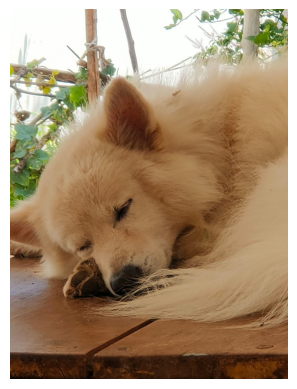

In [8]:
image_path = r'C:\Users\lucig\OneDrive\Desktop\Face Project\Project\Images\dog.jpg'
FER_image(image_path)